In [25]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [26]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [27]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 20, 10, 1, 6, 464076)

In [28]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-20 10:01:06,480 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-20 10:01:06,493 INFO: Initializing external client
2025-01-20 10:01:06,494 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-20 10:01:07,903 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [29]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION = STATION.replace(" ", "_")

In [30]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [31]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bike_availability_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [32]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

In [33]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-01-20 12:00:00+00:00,8.60,7.052317,0.1,0.0,6.763786,29881.912109,1.800000,dublin,1,0,12
1,2025-01-20 14:00:00+00:00,9.05,8.293173,0.0,0.0,1.297998,29881.912109,1.800000,dublin,1,0,14
2,2025-01-20 16:00:00+00:00,8.60,7.315358,0.0,0.0,4.693826,29881.912109,1.800000,dublin,1,0,16
3,2025-01-20 15:00:00+00:00,9.05,7.965399,0.0,0.0,3.545589,29881.912109,1.800000,dublin,1,0,15
4,2025-01-20 21:00:00+00:00,6.55,4.661989,0.1,0.0,6.489992,29881.912109,1.800000,dublin,1,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...
223,2025-01-26 20:00:00+00:00,8.20,0.811940,0.3,0.0,44.839874,31026.716797,7.500001,dublin,1,6,20
224,2025-01-28 14:00:00+00:00,6.45,2.070771,0.0,0.0,18.129137,31429.511719,0.000000,dublin,1,1,14
225,2025-01-27 22:00:00+00:00,6.10,0.947510,0.0,0.0,23.469128,31225.949219,2.699999,dublin,1,0,22
226,2025-01-21 20:00:00+00:00,4.00,1.136883,0.0,0.0,8.714677,30065.742188,0.000000,dublin,1,1,20


## Creating predictions

In [34]:
batch_data['predicted_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['predicted_bikes_available'] = batch_data['predicted_bikes_available'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available
0,2025-01-20 12:00:00+00:00,8.60,7.052317,0.1,0.0,6.763786,29881.912109,1.800000,dublin,1,0,12,5
1,2025-01-20 14:00:00+00:00,9.05,8.293173,0.0,0.0,1.297998,29881.912109,1.800000,dublin,1,0,14,5
2,2025-01-20 16:00:00+00:00,8.60,7.315358,0.0,0.0,4.693826,29881.912109,1.800000,dublin,1,0,16,8
3,2025-01-20 15:00:00+00:00,9.05,7.965399,0.0,0.0,3.545589,29881.912109,1.800000,dublin,1,0,15,6
4,2025-01-20 21:00:00+00:00,6.55,4.661989,0.1,0.0,6.489992,29881.912109,1.800000,dublin,1,0,21,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2025-01-26 20:00:00+00:00,8.20,0.811940,0.3,0.0,44.839874,31026.716797,7.500001,dublin,1,6,20,34
224,2025-01-28 14:00:00+00:00,6.45,2.070771,0.0,0.0,18.129137,31429.511719,0.000000,dublin,1,1,14,3
225,2025-01-27 22:00:00+00:00,6.10,0.947510,0.0,0.0,23.469128,31225.949219,2.699999,dublin,1,0,22,29
226,2025-01-21 20:00:00+00:00,4.00,1.136883,0.0,0.0,8.714677,30065.742188,0.000000,dublin,1,1,20,39


In [35]:
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
0,2025-01-20 12:00:00+00:00,8.60,7.052317,0.1,0.0,6.763786,29881.912109,1.8,dublin,1,0,12,5,1
5,2025-01-20 13:00:00+00:00,8.85,7.746639,0.0,0.0,3.877318,29881.912109,1.8,dublin,1,0,13,5,2
1,2025-01-20 14:00:00+00:00,9.05,8.293173,0.0,0.0,1.297998,29881.912109,1.8,dublin,1,0,14,5,3
3,2025-01-20 15:00:00+00:00,9.05,7.965399,0.0,0.0,3.545589,29881.912109,1.8,dublin,1,0,15,6,4
2,2025-01-20 16:00:00+00:00,8.60,7.315358,0.0,0.0,4.693826,29881.912109,1.8,dublin,1,0,16,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,2025-01-29 19:00:00+00:00,3.10,-0.518530,0.0,0.0,11.681987,31637.470703,0.0,dublin,1,2,19,37,224
149,2025-01-29 20:00:00+00:00,3.15,-0.574576,0.0,0.0,11.918120,31637.470703,0.0,dublin,1,2,20,37,225
15,2025-01-29 21:00:00+00:00,3.30,-0.619211,0.0,0.0,12.864649,31637.470703,0.0,dublin,1,2,21,37,226
116,2025-01-29 22:00:00+00:00,3.55,-0.637305,0.0,0.0,14.408997,31637.470703,0.0,dublin,1,2,22,37,227


## Create forecast graph

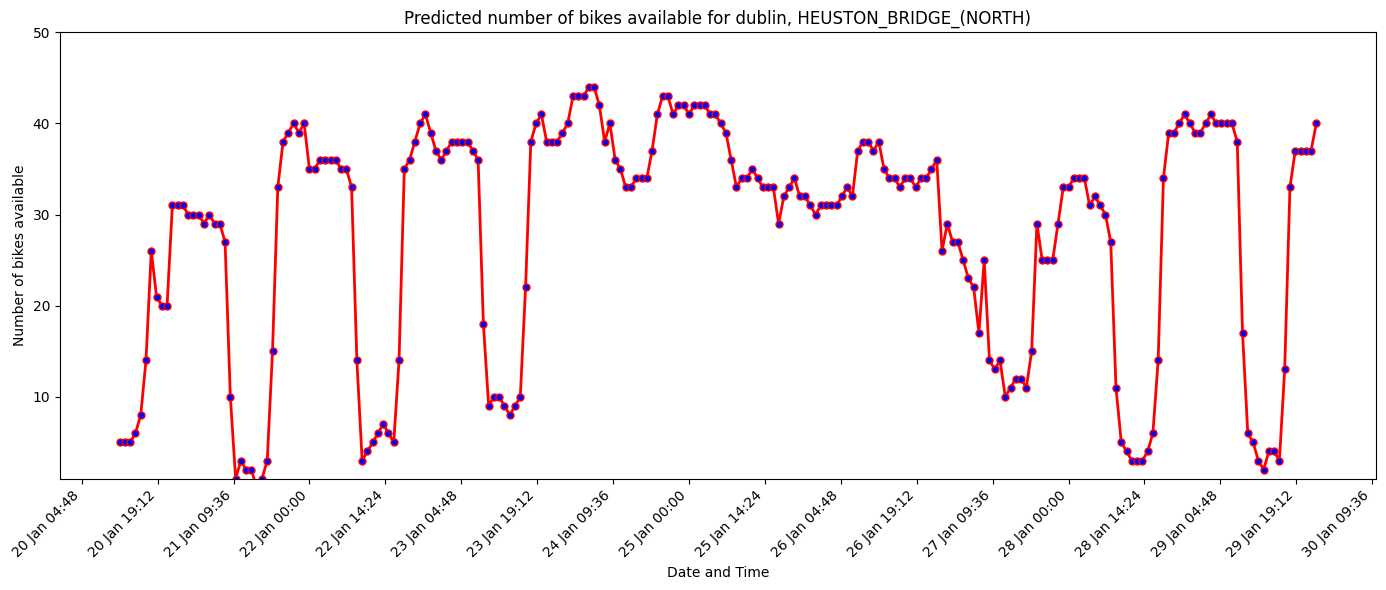

In [36]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, batch_data, file_path)
plt.show()

In [37]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bike_availability_predictions',
    description='Bike availability prediction monitoring for ' + STATION.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [38]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1207494/fs/1195126/fg/1395275


Uploading Dataframe: 100.00% |██████████| Rows 228/228 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: bike_availability_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions
2025-01-20 10:01:33,927 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-20 10:01:37,117 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-20 10:03:22,360 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-20 10:03:22,523 INFO: Waiting for log aggregation to finish.
2025-01-20 10:03:48,051 INFO: Execution finished successfully.


(Job('bike_availability_predictions_1_offline_fg_materialization', 'SPARK'),
 None)

In [39]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time <= 24).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
0,2025-01-20 12:00:00+00:00,8.60,7.052317,0.1,0.0,6.763786,29881.912109,1.8,dublin,1,0,12,5,1
1,2025-01-21 04:00:00+00:00,5.45,2.785907,0.0,0.0,10.365251,30065.742188,0.0,dublin,1,1,4,29,17
2,2025-01-21 03:00:00+00:00,5.50,2.913811,0.0,0.0,9.904906,30065.742188,0.0,dublin,1,1,3,30,16
3,2025-01-20 17:00:00+00:00,7.90,6.527549,0.0,0.0,4.896530,29881.912109,1.8,dublin,1,0,17,14,6
4,2025-01-21 09:00:00+00:00,5.10,2.046816,0.0,0.0,12.522619,30065.742188,0.0,dublin,1,1,9,10,22
5,2025-01-20 16:00:00+00:00,8.60,7.315358,0.0,0.0,4.693826,29881.912109,1.8,dublin,1,0,16,8,5
6,2025-01-21 08:00:00+00:00,5.15,2.169975,0.0,0.0,12.303366,30065.742188,0.0,dublin,1,1,8,27,21
7,2025-01-20 22:00:00+00:00,6.45,4.273693,0.0,0.0,8.311245,29881.912109,1.8,dublin,1,0,22,31,11
8,2025-01-21 02:00:00+00:00,5.75,3.186213,0.0,0.0,9.904906,30065.742188,0.0,dublin,1,1,2,30,15
9,2025-01-20 21:00:00+00:00,6.55,4.661989,0.1,0.0,6.489992,29881.912109,1.8,dublin,1,0,21,20,10


In [40]:
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
bike_df = bike_fg.read()
bike_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 


,datetime,station,num_bikes_available
0,2024-09-23 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),2.0
1,2023-10-07 13:00:00+00:00,HEUSTON_BRIDGE_(NORTH),29.0
2,2023-11-27 07:00:00+00:00,HEUSTON_BRIDGE_(NORTH),34.0
3,2024-01-22 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),35.0
4,2023-10-16 02:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
...,...,...,...
9545,2025-01-19 10:49:07+00:00,HEUSTON_BRIDGE_(NORTH),40.0
9546,2025-01-17 05:48:56+00:00,HEUSTON_BRIDGE_(NORTH),40.0
9547,2025-01-13 04:49:13+00:00,HEUSTON_BRIDGE_(NORTH),37.0
9548,2025-01-14 10:49:03+00:00,HEUSTON_BRIDGE_(NORTH),0.0


In [41]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,2024-11-17 07:00:00+00:00,6.6395,3.542508,0.0,0.0,13.091829,30647.093750,2.600000,dublin
1,2024-07-26 02:00:00+00:00,12.0395,9.959105,0.0,0.0,15.349684,57427.019531,0.900000,dublin
2,2024-08-02 09:00:00+00:00,18.9895,18.108223,0.0,0.0,19.469975,56053.718750,2.500000,dublin
3,2024-03-28 18:00:00+00:00,8.1395,6.004910,0.1,0.0,4.334974,46005.636719,1.300000,dublin
4,2024-01-09 08:00:00+00:00,3.7895,-1.855704,0.0,0.0,21.602999,28177.490234,0.000000,dublin
...,...,...,...,...,...,...,...,...,...
12979,2025-01-26 20:00:00+00:00,8.2000,0.811940,0.3,0.0,44.839874,31026.716797,7.500001,dublin
12980,2025-01-28 14:00:00+00:00,6.4500,2.070771,0.0,0.0,18.129137,31429.511719,0.000000,dublin
12981,2025-01-27 22:00:00+00:00,6.1000,0.947510,0.0,0.0,23.469128,31225.949219,2.699999,dublin
12982,2025-01-21 20:00:00+00:00,4.0000,1.136883,0.0,0.0,8.714677,30065.742188,0.000000,dublin


In [42]:
def backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, model):
    features_df = weather_fg.read()

    features_df["month"] = features_df["datetime"].dt.month
    features_df["weekday"] = features_df["datetime"].dt.weekday  # 0=Monday, 6=Sunday
    features_df["hour"] = features_df["datetime"].dt.hour

    features_df = pd.merge(features_df, bike_df[['datetime','num_bikes_available']], on="datetime")
    features_df = features_df.sort_values(by=['datetime'], ascending=True)
    features_df = features_df.tail(10*24)
    
    features_df['predicted_bikes_available'] = model.predict(features_df[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']])
    features_df['predicted_bikes_available'] = features_df['predicted_bikes_available'].apply(lambda x: round(x))

    features_df['hours_before_forecast_time'] = range(1, len(features_df) + 1)
    hindcast_df = features_df
    features_df = features_df.drop('num_bikes_available', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    return hindcast_df

In [43]:
outcome_df = bike_df[['datetime', 'num_bikes_available']]
preds_df =  monitoring_df[['datetime', 'predicted_bikes_available']]

hindcast_df = pd.merge(preds_df, outcome_df, on="datetime")
hindcast_df = hindcast_df.sort_values(by=['datetime'])
print(len(hindcast_df))
hindcast_df

0


,datetime,predicted_bikes_available,num_bikes_available


In [48]:
outcome_df = outcome_df.sort_values(by=['datetime'])
outcome_df

,datetime,num_bikes_available
5695,2023-08-07 02:00:00+00:00,10.0
2161,2023-08-07 03:00:00+00:00,10.0
3422,2023-08-07 04:00:00+00:00,10.0
8312,2023-08-07 05:00:00+00:00,10.0
2192,2023-08-07 06:00:00+00:00,10.0
...,...,...
9383,2025-01-19 19:49:09+00:00,33.0
9539,2025-01-19 20:49:10+00:00,33.0
9491,2025-01-19 21:49:00+00:00,33.0
9379,2025-01-19 22:49:03+00:00,34.0


In [49]:
preds_df = preds_df.sort_values(by=['datetime'])
preds_df

,datetime,predicted_bikes_available
0,2025-01-20 12:00:00+00:00,5
16,2025-01-20 13:00:00+00:00,5
17,2025-01-20 14:00:00+00:00,5
11,2025-01-20 15:00:00+00:00,6
5,2025-01-20 16:00:00+00:00,8
3,2025-01-20 17:00:00+00:00,14
22,2025-01-20 18:00:00+00:00,26
14,2025-01-20 19:00:00+00:00,21
15,2025-01-20 20:00:00+00:00,20
9,2025-01-20 21:00:00+00:00,20


In [44]:

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
print("Hindcast length: ", len(hindcast_df))
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Hindcast length:  0
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.59s) 


Uploading Dataframe: 100.00% |██████████| Rows 240/240 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: bike_availability_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions
2025-01-20 10:04:10,930 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-20 10:04:14,111 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-20 10:05:41,086 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-20 10:05:41,251 INFO: Waiting for log aggregation to finish.
2025-01-20 10:05:53,264 INFO: Execution finished successfully.


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,num_bikes_available,predicted_bikes_available,hours_before_forecast_time
4428,2024-12-28 16:00:00+00:00,8.539500,5.723537,0.0,0.0,14.941085,27194.826172,0.0,dublin,12,5,16,34.0,32,1
5717,2024-12-28 17:00:00+00:00,8.789500,5.991804,0.0,0.0,15.070633,27194.826172,0.0,dublin,12,5,17,33.0,31,2
7205,2024-12-28 18:00:00+00:00,9.139501,6.359324,0.0,0.0,15.380260,27194.826172,0.0,dublin,12,5,18,34.0,32,3
5998,2024-12-28 19:00:00+00:00,9.239500,6.363287,0.0,0.0,16.299694,27194.826172,0.0,dublin,12,5,19,33.0,32,4
8433,2024-12-28 20:00:00+00:00,9.289500,6.719114,0.0,0.0,14.731437,27194.826172,0.0,dublin,12,5,20,34.0,32,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9250,2025-01-08 11:00:00+00:00,0.050000,-2.757509,0.0,0.0,3.706427,28021.865234,0.0,dublin,1,2,11,39.0,9,236
9248,2025-01-08 12:00:00+00:00,1.400000,-1.355652,0.0,0.0,4.582052,28021.865234,0.0,dublin,1,2,12,38.0,9,237
9241,2025-01-08 13:00:00+00:00,2.100000,-0.793506,0.0,0.0,6.120000,28021.865234,0.0,dublin,1,2,13,39.0,8,238
9252,2025-01-08 14:00:00+00:00,2.450000,-0.681665,0.0,0.0,7.968939,28021.865234,0.0,dublin,1,2,14,39.0,7,239


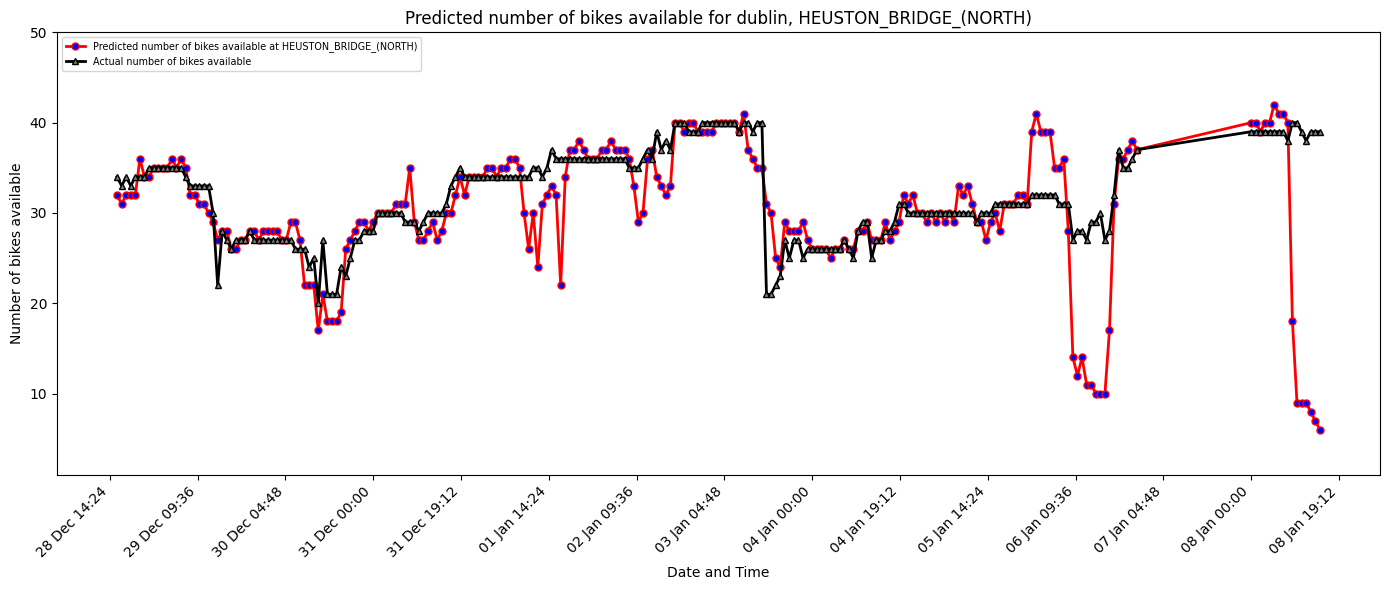

In [45]:
file_path = "docs/bike_availability_hindcast_1day.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, hindcast_df, file_path, hindcast=True)
plt.show()